In [1]:
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    plot_results_statistics,
    generate_results,
    plot_results_1d
)

%load_ext autoreload
#%reload_ext autoreload
%autoreload 2

2024-02-20 19:44:25.775768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# notebook parameters
random_seed = 1
step_size = .01  # step size

n_layers = 2
n_dim_per_layer = 50

n_dimensions = 3

ACTIVATIONS = tf.nn.leaky_relu
VALIDATION_SPLIT = .1
BATCH_SIZE = 64
N_EPOCHS = 100

xlim = [-.3, .3]

# full covariance matrix, here SPD type
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [3]:
x_data = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_x_stochastic_gamma1_withlib.csv',encoding='utf-8',header=None)
y_data = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_xt1_stochastic_gamma1_withlib.csv',encoding='utf-8',header=None)
x_data = x_data.values[:,0:3]
y_data = y_data.values[:,0:3]
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size


data shape (200000, 3)


In [4]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder,
                                method="euler",
                                diffusivity_type=diffusivity_type)

model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 50)           200         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 50)           200         ['GP_inputs[0][0]']              
                                                                                                  
 GP_mean_hidden_1 (Dense)       (None, 50)           2550        ['GP_mean_hidden_0[0][0]']       
                                                                                

2024-02-20 19:44:32.753443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


training for 100 epochs with 180000 data points, validating with 20000
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
The average loss for epoch 99 is 8.5502398983 Time comsuming: 397.42452573776245


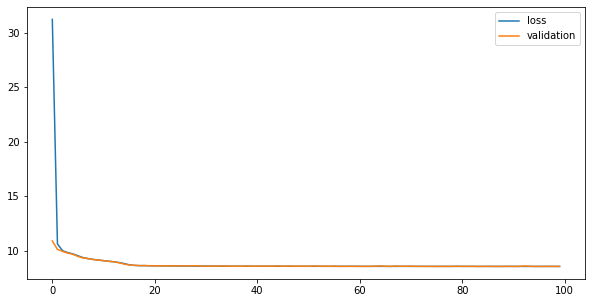

In [5]:
import time
starttime = time.time()
hist = sde_i.train_model(x_data, y_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT,
                         n_epochs=N_EPOCHS,
                         batch_size=BATCH_SIZE)

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()
endtime = time.time()
print('Time comsuming:', endtime-starttime)

In [6]:
print(f"Training loss final: {hist.history['loss'][-1]}")
print(f"Validation loss final: {hist.history['val_loss'][-1]}")

Training loss final: 8.550239898288387
Validation loss final: 8.549862062972773


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import scipy.spatial.distance

from sde.sde_learning_network import \
(
    SDEIntegrators
)


def sample_data(drift_diffusivity, step_size, n_dimensions, low, high, n_pts, rng, 
                n_subsample=1, param_low=None, param_high=None):
    x_data = rng.uniform(low=low, high=high, size=(n_pts, n_dimensions))
    y_data = x_data.copy()
    if param_high is not None:
        n_param = np.atleast_1d(param_high).shape[0]
        p_data = rng.uniform(low=param_low, high=param_high, size=(n_pts, n_param))
        for k in range(n_subsample):
            y_data = np.row_stack([
                SDEIntegrators.euler_maruyama(y_data[k, :],
                                            step_size / n_subsample,
                                            drift_diffusivity,
                                            rng,
                                            p_data[k, :])
                for k in range(x_data.shape[0])
            ])
    else:
        for k in range(n_subsample):
            y_data = np.row_stack([
                SDEIntegrators.euler_maruyama(y_data[k, :],
                                            step_size / n_subsample,
                                            drift_diffusivity,
                                            rng)
                for k in range(x_data.shape[0])
            ])

    if param_high is not None:
        return x_data, y_data, p_data
    else:
        return x_data, y_data


def plot_results_functions(apx_drift_diffusivity, 
                           x_data, y_data, rng,
                           p_data=None,
                           data_transform_network=None,
                           data_transform_true=None,
                           fig=None, ax=None, color_approx="red", color_true="black"):
    if data_transform_network is None:
        def data_transform_network(x):
            return x
    if data_transform_true is None:
        def data_transform_true(x):
            return x
    if p_data is not None:
        mean_network, std_network = apx_drift_diffusivity(data_transform_network(x_data).astype(np.float32), p_data)
    else:
        mean_network, std_network = apx_drift_diffusivity(data_transform_network(x_data).astype(np.float32))

    mean_network = keras.backend.eval(mean_network)
    std_network = keras.backend.eval(std_network)

    if std_network.shape != mean_network.shape:
        std_network = keras.backend.eval(tf.linalg.diag_part(std_network))

    std_network_results = pd.DataFrame(mean_network)
    std_network_results.to_csv("/Users/lana_g/Desktop/symbolic regression/sde-identification-master/HindmarshRose_0.1_intensity/inferred_Lorenz_3dim_results.csv",index=0)

    n_dimensions = x_data.shape[1]

    ms = 0.25  # marker size

    x_data_transformed = data_transform_true(x_data)
    # if p_data is not None:
    #     true_drift_evaluated, true_std_evaluated = true_drift_diffusivity(x_data_transformed, p_data)
    # else:
    #     true_drift_evaluated, true_std_evaluated = true_drift_diffusivity(x_data_transformed)
    

    true_drift_evaluated = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_F_stochastic_gamma1_all.csv',encoding='utf-8',header=None)
    true_std_evaluated = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_sto_stochastic_gamma1_all.csv',encoding='utf-8',header=None)
    true_drift_evaluated = true_drift_evaluated.values
    true_std_evaluated = np.abs(true_std_evaluated.values)
    L = 10000
    true_drift_evaluated = true_drift_evaluated[0:L,:]
    true_std_evaluated = true_std_evaluated[0:L,:]


    if true_std_evaluated.shape != true_drift_evaluated.shape:
        true_std_evaluated = tf.linalg.diag_part(true_std_evaluated)

    if n_dimensions == 1:
        mean_network = mean_network.reshape(-1, 1)
        std_network = std_network.reshape(-1, 1)
        
        idx_ = np.argsort(x_data_transformed.ravel())

        if fig is None:
            fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].plot(x_data_transformed[idx_], true_drift_evaluated[idx_], "-", color=color_true, label="true")
        ax[0].plot(x_data_transformed[idx_], mean_network[idx_, 0], ".:", markevery=len(x_data_transformed)//21,
                   color=color_approx, label="approximated")
        ax[0].set_xlabel("Space")
        ax[0].set_ylabel("Drift")
        ax[0].legend()

        ax[1].plot(x_data_transformed[idx_], true_std_evaluated[idx_], "-", color=color_true, label="true")
        ax[1].plot(x_data_transformed[idx_], std_network[idx_, 0], ".:", markevery=len(x_data_transformed)//21,
                   color=color_approx, label="approximated")
        ax[1].set_xlabel("Space")
        ax[1].set_ylabel("Diffusivity")
        ax[1].legend()
    else:
        if fig is None:
            fig, ax = plt.subplots(2, n_dimensions, figsize=(n_dimensions * 4.5, 9))

        for k in range(n_dimensions):
            identity_pts = np.linspace(np.min([np.min(mean_network[:, k]), np.min(true_drift_evaluated)]),
                                       np.max([np.max(mean_network[:, k]), np.max(true_drift_evaluated)]),
                                       10)

            ax[0, k].scatter(true_drift_evaluated[:, k],mean_network[0:L, k], s=ms, label="approximation")
            #ax[0, k].plot(identity_pts, identity_pts, 'k--', label="identity")
            ax[0, k].plot((0, 1), (0, 1), transform=ax[0, k].transAxes, ls='--',c='k', label="1:1 line")
            parameterz = np.polyfit(true_drift_evaluated[:, k],mean_network[0:L, k],1)
            fx = np.poly1d(parameterz)
            ax[0,k].plot(true_drift_evaluated[:, k],fx(true_drift_evaluated[:, k]),'b--',lw=3)
            corrx = np.corrcoef(true_drift_evaluated[:, k],mean_network[0:L, k])[0,1]
            bbox = dict(fc='1',alpha=0.5)
            plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax[0, k].transAxes, size=10, bbox=bbox)
            ax[0, k].set_xlabel(r"true drift $f_" + str(k + 1) + "$")
            ax[0, k].set_ylabel(r"network drift $f_" + str(k + 1) + "$")
            ax[0, k].legend(loc="upper right")


            identity_pts = np.linspace(np.min([np.min(std_network[:, k]), np.min(true_std_evaluated)]),
                                       np.max([np.max(std_network[:, k]), np.max(true_std_evaluated)]),
                                       10)

            ax[1, k].scatter(true_std_evaluated[:, k],std_network[0:L, k], s=ms, label="approximation")
            #ax[1, k].plot(identity_pts, identity_pts, 'k--', label="identity")
            ax[1, k].plot((0, 1), (0, 1), transform=ax[1, k].transAxes, ls='--',c='k', label="1:1 line")
            parameterz = np.polyfit(true_std_evaluated[:, k],std_network[0:L, k],1)
            fx = np.poly1d(parameterz)
            ax[1,k].plot(true_std_evaluated[:, k],fx(true_std_evaluated[:, k]),'b--',lw=3)
            corrx = np.corrcoef(true_std_evaluated[:, k],std_network[0:L, k])[0,1]
            bbox = dict(fc='1',alpha=0.5)
            plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax[1, k].transAxes, size=10, bbox=bbox)
            ax[1, k].set_ylabel(r"network diffusivity $\sigma_" + str(k + 1) + "$")
            ax[1, k].set_xlabel(r"true diffusivity $\sigma_" + str(k + 1) + "$")
            ax[1, k].legend(loc="upper right")
    fig.tight_layout()
    return fig, ax


def generate_results(apx_drift_diffusivity,
                     step_size, x_data, rng, T_steps=25, N_iterates=10,
                     data_transform=None,
                     data_backtransform=None,
                     p_data=None):
    """
    x_data is used to sample initial conditions (N*p) matrix, with N initial conditions of dimension p.
    """
    if data_transform is None:
        data_transform = lambda x: x
    if data_backtransform is None:
        data_backtransform = lambda x: x

    def generate_path(f_sigma_, _x0, N, _p0=None):
        y_next = np.zeros((N, _x0.shape[1]))
        y_next[0, :] = _x0
        if _p0 is not None:
            for k in range(1, N):
                y_next[k, :] = SDEIntegrators.euler_maruyama(y_next[k - 1, :].reshape(1, -1),
                                                         step_size,
                                                         f_sigma_,
                                                         rng,
                                                         param=_p0)
            return y_next
        else:
            for k in range(1, N):
                y_next[k, :] = SDEIntegrators.euler_maruyama(y_next[k - 1, :].reshape(1, -1),
                                                         step_size,
                                                         f_sigma_,
                                                         rng)
            return y_next

    time_steps = [np.arange(T_steps) * step_size] * N_iterates
    paths_ = []

    for k in range(N_iterates):
        if p_data is not None:
            p0 = p_data[k % x_data.shape[0], :].reshape(1, -1)
            path_ = generate_path(apx_drift_diffusivity, data_transform(x_data[k % x_data.shape[0], :].reshape(1, -1)),
                              T_steps, _p0=p0)
            paths_.append(data_backtransform(path_))
        else:
            path_ = generate_path(apx_drift_diffusivity, data_transform(x_data[k % x_data.shape[0], :].reshape(1, -1)),
                              T_steps)
            paths_.append(data_backtransform(path_))
         

    return time_steps, paths_


def plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=1):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    if len(time_steps) == len(paths_network):
        time_steps = time_steps[0]

    for k in range(len(paths_network)):
        path_network = paths_network[k]
        path_true = paths_true[k]

        ax.plot(time_steps, path_network[:, plot_dim], 'r-', linewidth=linewidth,
                label='paths with network sde_model' if k == 0 else None)
        ax.plot(time_steps, path_true[:, plot_dim], 'k-', linewidth=linewidth,
                label='paths with SDE sde_model' if k == 0 else None)

    ax.set_xlabel("time")
    ax.set_ylabel("variable")

    ax.legend()
    fig.tight_layout()

    return fig


def plot_results_statistics(ax_, times_, paths_, dimension, color, label=None):
    """
    Visualizes mean and standard deviation of given sample paths.
    """
    paths_mean = np.mean(paths_, axis=0)
    paths_std = np.std(paths_, axis=0)
    ax_.plot(times_, paths_mean[:, dimension], color=color, label=label + " mean")
    ax_.plot(times_, paths_mean[:, dimension]+paths_std[:, dimension], ":", color=color, label=label+ r" $\pm$std")
    ax_.plot(times_, paths_mean[:, dimension]-paths_std[:, dimension], ":", color=color)


def probability_density(t, _generate_results, step_size, rng, plot_dim=0, N_iterates=10):
    """
    Samples the probability density of the given dimension at the given time.
    
    generate_results has to be a method from (step_size, T_steps, N_iterates) to (time_steps, paths_network, paths_true).
    Use generate_results_1d above as an example.
    """

    T_steps = int(t / step_size)

    time_steps, paths_ = _generate_results(step_size, T_steps=T_steps, N_iterates=N_iterates);

    pre_final_ = np.row_stack([pt[-2, :] for pt in paths_])
    final_ = np.row_stack([pt[-1, :] for pt in paths_])

    _pre_final_timestep = np.array([time_steps[k][-2] for k in range(len(time_steps))])
    _final_timestep = np.array([time_steps[k][-1] for k in range(len(time_steps))])

    final_ = np.row_stack([
        [
            np.poly1d(np.polyfit([_pre_final_timestep[k], _final_timestep[k]], [pre_final_[k, i], final_[k, i]], 1))(t)
            for i in range(pre_final_.shape[1])
        ]
        for k in range(len(_pre_final_timestep))
    ])

    for k in range(len(time_steps)):
        _t = time_steps[k]
        _t[-1] = t
        time_steps[k] = _t
    return final_, time_steps, paths_


def sinkhorn(points_A, points_B, n_iterations=5, kernel_scale=5e-2):
    """
    Computing the Sinkhorn algorithm between points a and b,
    as published by Cuturi (lightspeed optimal transport).
    """
    
    # squared pairwise distances with covariance = I
    _M = scipy.spatial.distance.cdist(points_A, points_B)**2

    local_kernel_scale = np.mean(_M)*kernel_scale

    _K = np.exp(-_M/local_kernel_scale)

    _x = np.ones_like(points_A)[:, :1]
    _r = np.ones_like(points_A)[:, :1]
    _c = np.ones_like(points_A)[:, :1]

    _x = _x / np.sum(_x)
    _r = _r / np.sum(_r)
    _c = _c / np.sum(_c)

    _U = _K * _M

    double_safe = 1e-15
    double_max = 1e5

    for i in range(n_iterations):
        _x = _r / np.clip(_K @ (_c / np.clip(np.transpose(_K) @ _x, double_safe, double_max)), double_safe, double_max)

    _v = _c / np.clip(np.transpose(_K) @ _x, double_safe, double_max)
    d_M = np.sum(_x * (_U @ _v))
    # _Plam = tf.linalg.diag(_u) @ _K @ tf.linalg.diag(_v)

    return d_M

/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


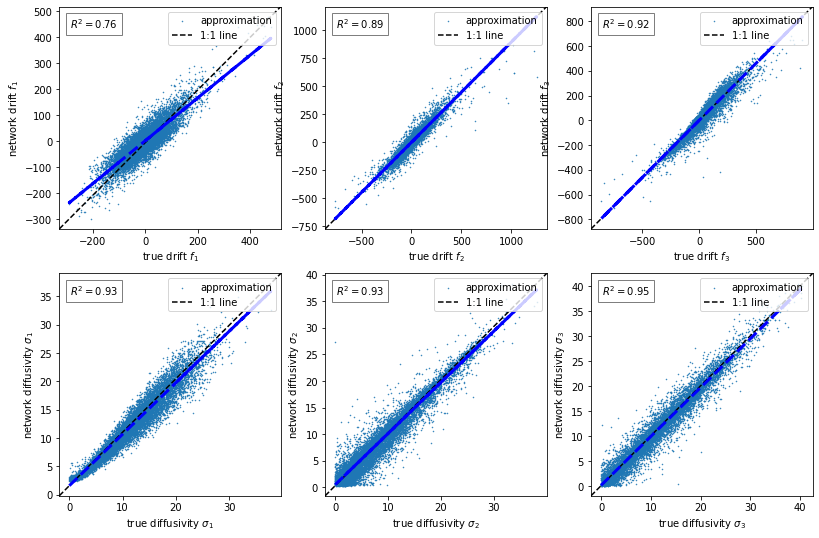

In [8]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i.drift_diffusivity, 
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)


# for k in range(2):
#     ax[1, k].set_xlim([0, .5])
#     ax[1, k].set_ylim([0, .5])

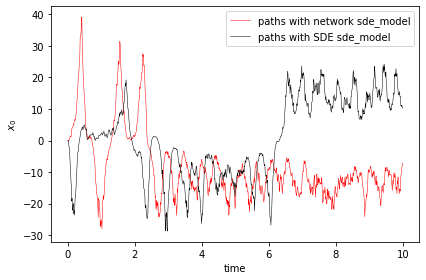

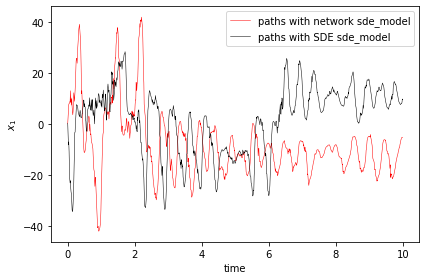

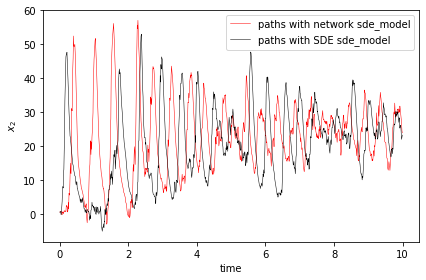

In [9]:
T_steps = 1000
N_iterates = 1

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

# time_steps, paths_true = \
#     generate_results(true_drift_diffusivity,
#                      step_size, x_data, rng,
#                      T_steps=T_steps, N_iterates=N_iterates);
paths_true = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_x_stochastic_gamma1.csv',encoding='utf-8',header=None)
paths_true = paths_true.values
paths_true = paths_true[0:1000,0:3].reshape(1,-1,3)
for k in range(n_dimensions):
    plot_results_1d(time_steps, paths_network, paths_true, plot_dim=k, linewidth=.5);
    plt.gca().set_ylabel(fr"$x_{k}$");

In [50]:
results = pd.read_csv('/Users/lana_g/Desktop/symbolic regression/sde-identification-master/HindmarshRose_0.1_intensity/inferred_Lorenz_3dim_results.csv',encoding='utf-8') #the drift part

In [51]:
results.shape

(200000, 3)

In [52]:
goal = results

In [53]:
import sys
from ElementaryFunctionsPool import *
from ElementaryFunctions_Matrix import *

In [54]:
A = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz2nodesAdj.csv',encoding='utf-8',header=None)
A = A.values

In [55]:
data = np.zeros((10000,60))

for i in range(20):
    data[:,i*3:i*3+3] = x_data[i*10000:(i+1)*10000,:]

In [56]:
#data = x_data.copy()

In [57]:
# import sys
# sys.path.append("/Users/lana_g/Desktop/symbolic regression/symbolic_deep_learning-master")
# import Self_func
# from Self_func import *
# Dimension = 3
# self_matrix = self_ElementaryFunctions_Matrix(data, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
#     ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
# self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# X = self_matrix.copy()
# y = goal.copy()

# X_mat = X.values 
# y_mat = y.values
# x_norml1 = []
# y_norml1 = []
# num = np.shape(X_mat)[1]
# num2 = 3
# L = np.shape(X_mat)[0]

# for i in range(0,num):
#     x_norml1.append(sum(abs(X_mat[:,i])))

# for i in range(0,num2):
#     y_norml1.append(sum(abs(y_mat[:,i])))

# X = pd.DataFrame(X)
# y = pd.DataFrame(y)

# X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
# y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

# X_col = X.columns 
# Xin = X.iloc[:,:]
# out = np.array(y)
# y1 = (out[:,0])

# reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=5000, normalize=False).fit(Xin,y1)
# print(reg1.score(Xin,y1))
# print('Best threshold: %.3f' % reg1.alpha_)

In [58]:
# for i in range(len(reg1.coef_)):
#         reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
# coef1 = pd.Series(reg1.coef_, index = X_col)
# imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
#                      coef1.sort_values(key=abs).tail(int(10))])
# imp_no_cons = imp_ + (1e-10)
# print("Elementary functions discovered by Phase 1 without constant.")
# print(imp_no_cons)

In [59]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LinearRegression(fit_intercept=intercept).fit(X_lib,Y_goal)
#     print(X_lib.columns)
#     print(reg.coef_)
#     if intercept == True:
#         coef['constant'] = reg.intercept_
#         num_params = len(coef)
#     else:
#         num_params = len(coef) 
    num_params = X_lib.shape[1]
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    #sort = coef.sort_values()
    return Score, mse, aic

In [60]:
# X = pd.DataFrame()
# Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
# MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
# AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
# y = goal.copy()
# for i in range(1,imp_no_cons.shape[0]+1):
#     tmp = self_matrix.copy()[imp_no_cons.index[-i]]
#     if i == 1:
#         X = self_matrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
#         X = pd.DataFrame(X)
#     else:
#         X = pd.concat([X,tmp],axis=1)
#     Score, mse, aic = terms_sort_fit(X,y,False)
#     Score_list[i-1] = Score
#     MSE_list[i-1] = mse
#     AIC_list[i-1] = aic
#     print(Score, mse, aic,imp_no_cons.index[-i])

In [61]:
Dim=3
Nnodes = 20
selfPolyOrder = 3

In [62]:
Matrix = ElementaryFunctions_Matrix(data, Dim, Nnodes, A, selfPolyOrder, coupledPolyOrder = 1, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False, RescalingIndex = False, CoupledPolynomialIndex = True, \
        CoupledTrigonometricIndex = True, CoupledExponentialIndex = False, CoupledFractionalIndex = False, \
            CoupledActivationIndex = False, CoupledRescalingIndex = False)

In [63]:
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 

In [64]:
X = Matrix.copy()
y = goal.copy()
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 3
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)

y1 = (out[:,1])

In [65]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 

In [66]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LinearRegression(fit_intercept=intercept).fit(X_lib,Y_goal)
#     print(X_lib.columns)
#     if intercept == True:
#         coef['constant'] = reg.intercept_
#         num_params = len(coef)
#     else:
#         num_params = len(coef) 
    num_params = X_lib.shape[1]
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    #sort = coef.sort_values()
    return Score, mse, aic

In [67]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(np.float64(Xin),np.float64(y1))
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


0.9859330802904795
Best threshold: 0.006


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LassoCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [68]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 without constant.
x3x3x3     0.000052
x1x1x3     0.000157
x2x2x2    -0.000380
x2x3x3    -0.000473
x1x1x1     0.000601
x2x2      -0.003409
x2x3      -0.037818
x1j        0.044596
x1x3      -0.511782
x1        13.888172
dtype: float64


In [69]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = Matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = Matrix.copy()[imp_cons.index[-i]].values.reshape(-1,1)
            X = pd.DataFrame(X)
        else:
            X = pd.concat([X,tmp],axis=1)
    else:
        Cons = np.ones((y1.shape[0],1))*imp_cons['constant']
        X = pd.DataFrame(Cons)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])

0.024551461443941158 10599.867653046043 1853721.358892104 x1
0.43676220754338196 6625.207340314017 1759731.389403173 x1x3
0.46803197109052097 6472.1367864016065 1755058.31872406 x1j


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', '

0.639478767818133 5514.259774181327 1723026.5404445073 x2x3
0.757556731966802 3576.0282430415114 1636411.6068408948 x2x2
0.7699985931716302 3456.432081612105 1629610.4291447517 x1x1x1


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', '

0.7736472763552061 3439.120676201464 1628608.2200616915 x2x3x3


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', '

0.7750902103070869 3423.0247554084544 1627671.9741167258 x2x2x2
0.7952914702253332 3095.62540829175 1607567.0470471298 x1x1x3
0.8671113475239928 1904.7838265365979 1510444.7608476274 x3x3x3


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', '